In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from aeon.datasets import load_classification

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [55]:
print("Carregando StarLightCurves...")

X_train, y_train = load_classification("StarLightCurves", split="train")

X_test, y_test = load_classification("StarLightCurves", split="test")



print(f"Shape treino: {X_train.shape}")

print(f"Shape teste: {X_test.shape}")

Carregando StarLightCurves...
Shape treino: (1000, 1, 1024)
Shape teste: (8236, 1, 1024)


In [56]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Shape achatado: {X_train_flat.shape}")

Shape achatado: (1000, 1024)


In [28]:
X_train_tensor = torch.FloatTensor(X_train_flat)
X_test_tensor = torch.FloatTensor(X_test_flat)

In [29]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [30]:
input_dim = X_train_flat.shape[1]
bottleneck_percent = 0.5  # 50% do tamanho original
latent_dim = int(input_dim * bottleneck_percent)

In [44]:
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nModelo: {input_dim} -> {latent_dim} -> {input_dim}")


Modelo: 1024 -> 512 -> 1024


In [46]:
# Treinar
num_epochs = 100

print("Treinando...")
for epoch in range(num_epochs):
    for data, _ in train_loader:
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Treinamento concluído!")

Treinando...
Treinamento concluído!


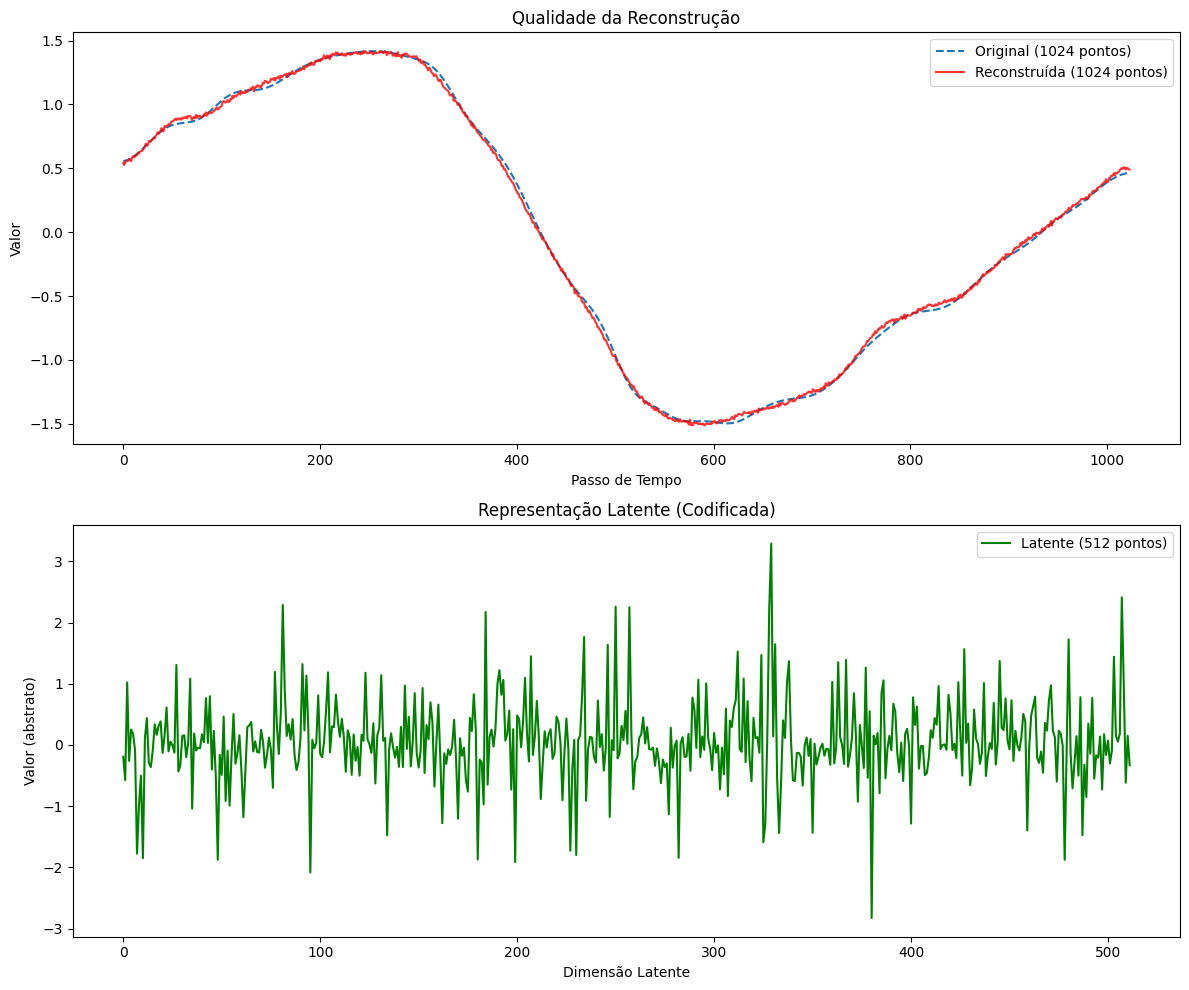

In [52]:
# Obter as três versões da série
model.eval()
with torch.no_grad():
    # Pegue a amostra (índice 20)
    original_data = X_test_tensor[20]
    
    # Versão Latente (Codificada)
    latent_data = model.encode(original_data).numpy()
    
    # Versão Reconstruída
    # (Passa pelo encoder E pelo decoder)
    reconstructed_data = model(original_data).numpy() 

# Plotar tudo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Gráfico 1: Original vs. Reconstruída ---
ax1.plot(original_data.numpy(), label='Original (1024 pontos)', linestyle='--')
ax1.plot(reconstructed_data, label='Reconstruída (1024 pontos)', color='red', alpha=0.8)
ax1.legend()
ax1.set_title('Qualidade da Reconstrução')
ax1.set_xlabel('Passo de Tempo')
ax1.set_ylabel('Valor')

# --- Gráfico 2: A Representação Latente ---
ax2.plot(latent_data, label=f'Latente ({latent_dim} pontos)', color='green')
ax2.legend()
ax2.set_title('Representação Latente (Codificada)')
ax2.set_xlabel('Dimensão Latente')
ax2.set_ylabel('Valor (abstrato)')

plt.tight_layout()
plt.show()